# 5SSG2060 Spatial Analysis: Assessment 1 (Coding 1)

This assignment comprises 20% of the TOTAL MARK for this module.
The submission deadline is <font style="color:red">**23:30 on 26 February 2020**</font>.

Provide code below to complete the tasks. There are 2 tasks in this assignment, with 20 marks available in total (marks available for each task are noted). 

Marks for each Task will be weighted: 
- 40% for _functionality_ (i.e. does the code complete the task as required?) 
- 30% for _efficiency and elegance_ (i.e. is this a logical and succinct way of completing the task?), and 
- 30% for _observation and interpretation_ (i.e. What patterns do the map and the KDE surface show, and why do you think those patterns are present?). 

Suggestions and hints are provided for some questions.

You will need to download AirBNB data either from KEATS or copied from your practicals in previous weeks before beginning the Tasks. Also use the London LSOA map as the base layer for drawing a map. Make sure you save the data in a location that is accessible by jupyter.

You should save your final notebook file in the format <i>5SSG2060\_CW1\_StudentIDNumber.ipynb</i> and submit in the relevant location [on KEATS](https://keats.kcl.ac.uk/course/view.php?id=65825) by the deadline above.

## Setup

The code in the next code block imports required libraries, and sets plots to appear properly inline in the notebook. You _must_ run this code block for the code in the rest of the notebook to work. Do not delete or otherwise modify this block, and _note their aliases for your later code_.

In [2]:
import os
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
import random
random.seed(12345)

%matplotlib inline

## Task 1 Create a Map of AirBNB Sample Data <font style="color:red">(Total 8 marks available) </font>

Assuming you have already unzipped the datafiles to disk, 
- Read the AirBNB file into a pandas/geopandas DataFrame named `df`. 
- Using the random seed, take a fraction (1%) of the dataset as sample set named `dfs`.
- Save the sample set as a shapefile  (this is named as `listings_sample.shp` below but you can change it if you like). Save it in a suitable location/folder (this is named as `shapes` below but you can change it if you like).
- Create a map of the sample locations. In doing so, classify (and color code) the locations into 5 classes based on the range of advertised price. You can use a 'natural-breaks' method such as Fisher-Jenks or, if you wish to try something different, perhaps 'quantile' or 'equidistance' and see what happens. 
- **Bonus Challenge**: Try to plot them on top of the LSOA base map.

To get you started, some lines are added as below.

In [3]:
#Read AIRBNB file in to pandas DF
df= pd.read_csv(os.path.join('data','Airbnb_Listings_London.csv'))
# to make the numbers more legible
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
#Take 1% fraction for sample
dfs = df.sample(frac=0.01)
#Configure geomerty and CRS
geometry = dfs.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
crs      = {'init': 'epsg:4326'}
#Convert into GeoPandas Shape file
spdf     = gpd.GeoDataFrame(dfs, crs=crs, geometry=geometry)
#Reproject for OSGB 1936, with a EPSG value of 27700
spdf     = spdf.to_crs({'init': 'epsg:27700'})
#save shapefile in suitable place 
if not os.path.isdir('shapes'):  
    os.mkdir('shapes')
spdf.to_file(os.path.join('shapes','listings_sample.shp'))

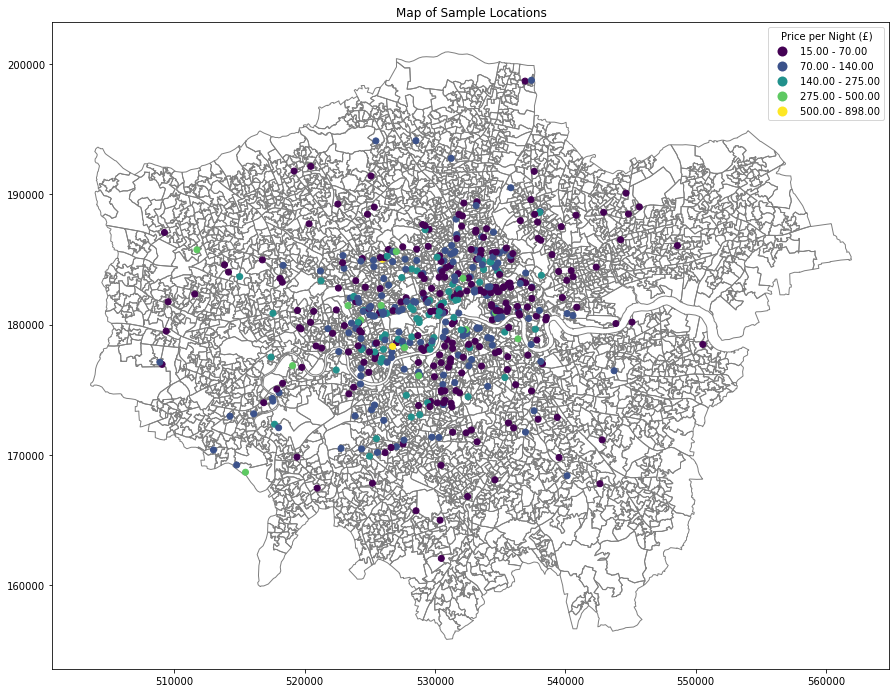

In [38]:
#Now for the map, starting by loading LSOA base map
#Read from github 
pdf = lon = pd.read_csv('https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA%20Data.csv.gz?raw=true',compression='gzip', low_memory=False)
#Convert to geopandas dataframe
gdf = gpd.GeoDataFrame(pdf)
#Assign geometry 
from shapely.wkt import loads
gdf['geometry'] = gdf['geometry'].apply(lambda x: loads(x))
gdf = gdf.set_geometry('geometry')

#creating map of sample locations 
#Setting figure 
fig, ax = plt.subplots(1, figsize=(15, 12))
#LSOA baselayer
gdf.plot(ax=ax, edgecolor='grey', facecolor='None', zorder=1)
#Plotting of sample data, using natural breaks onto same axis
spdf.plot(ax=ax, column='price', scheme='natural_breaks', k=5, zorder=2, legend=True)
#Adding extra info onto plot
ax.set_title('Map of Sample Locations')
ax.get_legend().set_title( 'Price per Night (£)')
#Saving
plt.savefig("Map of Sample AIRBNB Locations", dpi=300) 

## Task 2 Kernel Density Estimation (KDE) <font style="color:red">(Total 12 marks available) </font>

Using the sample point set,
- Create a KDE map for the whole sample set. You may wish to use the jointplot function of seaborn (as below), or kdeplot function. Alternatively, you can search and download one of the several kernel density codes available on github and other places.
- Select one of the 5 classes of the price range and extract only the sample locations that match this class. Save this set as `dfs_s`.
- Plot the sample locations that belong to `dfs_s` only.
- Create a KDE map of the sample locations that belong to `dfs_s` only.
- Provide brief interpretations for each of your KDE map as comments
- **Bonus Challenge**: Do you see a considerable difference between the whole sample set (`dfs`) and the subset (`dfs_s`)? If so, why do you think that is the case? Please add your thoughts as comments.

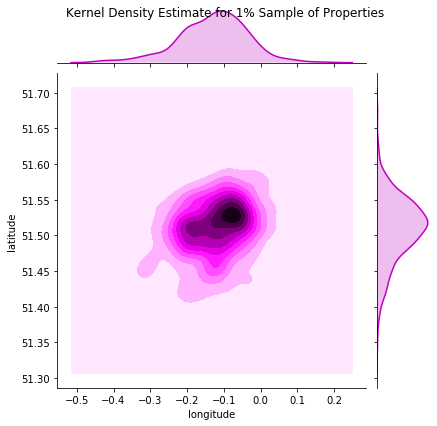

In [19]:
#KDE plot for whole sample set
g = sns.jointplot(x='longitude', y='latitude', data=spdf, kind="kde", color="m")
g.fig.suptitle('Kernel Density Estimate for 1% Sample of Properties')
g.savefig("KDE of Sample AIRBNB", dpi=300) 

###### This KDE map shows a concetration like that of the zones of London. The highest density is roughly the location of Shoreditch, which is an hotspot for tourists especially those looking to experince a 'different' london from that of cetral London. Central London causes the oblong to the left. As distance from zone 1 increases, the presenece of airbnb's decrease. This relationship is due to tourist activities (ie attractions) not being located in these areas.The petrusion at -0.3, 51.45 is the locaiton of Heathrow, where many toursits will be looking for an overnight AIRBNB for flights at inconveniant times.   

In [30]:
#Selecting first class (via equal split method, £9-90)
#Creating empty df called dfs_s
dfs_s = gpd.GeoDataFrame()
#Extracting just locations depedning on the price 
dfs_s['latitude']=spdf['latitude'][(spdf['price']<=70)&(spdf['price']>=15)]
dfs_s['longitude']=spdf['longitude'][(spdf['price']<=70)&(spdf['price']>=15)]
#Convert to geopanda shape file, in case want to plot
geometry = dfs.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
crs = {'init': 'epsg:4326'} 
dfs_s     = gpd.GeoDataFrame(dfs_s, crs=crs, geometry=geometry)
dfs_s    = dfs_s.to_crs({'init': 'epsg:27700'})
#Saving in suitable location 
dfs_s.to_file(os.path.join('data','£15-£70class'))

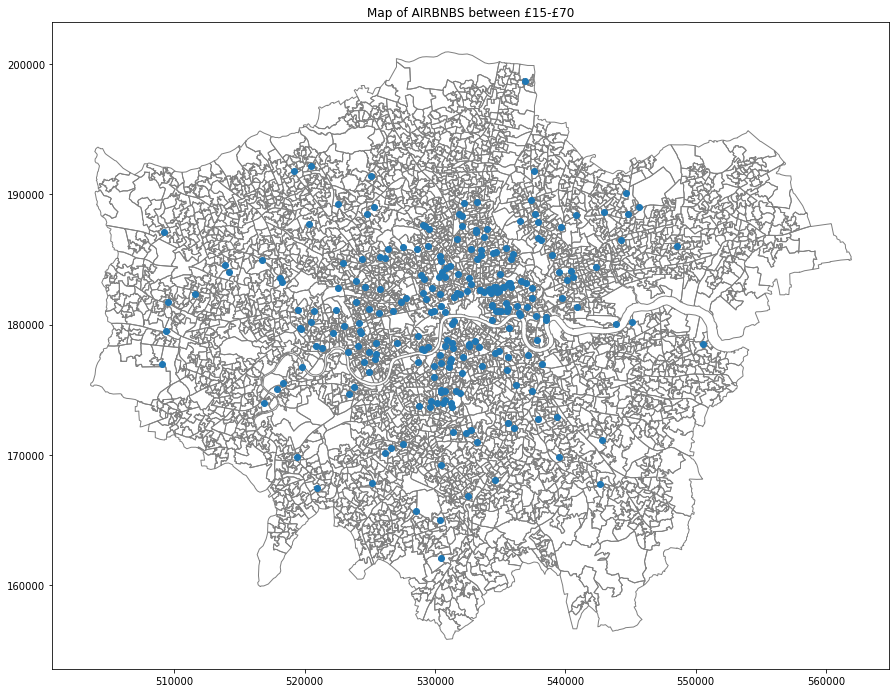

In [33]:
#creating map of dfs_s locations using method from question 1
#Setting figure 
fig, ax = plt.subplots(1, figsize=(15, 12))
#LSOA baselayer
gdf.plot(ax=ax, edgecolor='grey', facecolor='None', zorder=1)
#Plotting of sample data, using natural breaks onto same axis
dfs_s.plot(ax=ax, zorder=2)
#Adding extra info onto plot
ax.set_title('Map of AIRBNBS between £15-£70')
#Saving
plt.savefig("Map of AIRBNBS between £15-£70", dpi=300) 

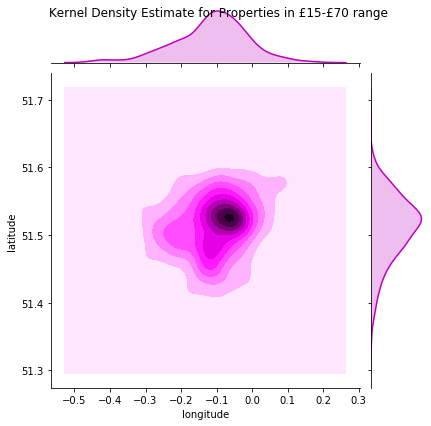

In [35]:
#KDE for dfs_s
f = sns.jointplot(x='longitude', y='latitude', data=dfs_s, kind="kde", color="m")
f.fig.suptitle('Kernel Density Estimate for Properties in £15-£70 range')
g.savefig("KDE of AIRBNB costing £15-£70", dpi=300) 

###### This KDE shows a very similar pattern to the previous KDE. This is due to 246 out of 493 aibnbs costing between £15-£75/night. There are less located in Heathrow, and central london (particularly Westminster). This is caused by these areas being in higher demand, so thus have higher prices exluded in this grouping. There is a 'spike' in north east London (0.11,51.59), potentially in Hackney which is another area of gentrification similar to Shoreditch. Despite this, the overall pattern stays the same due to many AIRBNBs falling into the 15-75 range.